# *Webscrapen aus Webpage und in die Postgres DB schreiben*

In [2]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import json
import psycopg2

# Verbindung zur Datenbank herstellen
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin"
)

# Tabelle erstellen, wenn sie nicht existiert
with conn.cursor() as cursor:
    cursor.execute('CREATE TABLE IF NOT EXISTS autos (id SERIAL PRIMARY KEY, model TEXT, price INTEGER, currency TEXT, year TEXT, address TEXT, mileage TEXT, fuel_type TEXT, engine_power INTEGER)')
    conn.commit()

# Set up the driver
driver = webdriver.Chrome(ChromeDriverManager().install())
# Define the base URL
base_url = 'https://www.autoscout24.ch/de/autos/audi--a5?make=5&uprop=2&model=27&page={}&vehtyp=10'

# Initialize an empty list to store data
data = []
page = 1
while True:
    # Build the URL for the current page
    url = base_url.format(page)
    # Navigate to the URL
    driver.get(url)
    # Check if "Kein Treffer" is found
    if "Keine Treffer" in driver.page_source:
        break

    # Increment the page number
    page += 1
    # Wait for the cookie button to be clickable and click it
    try:
        cookie_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, '//button[contains(text(),"Akzeptieren")]'))
        )
        cookie_button.click()
    except:
        pass

    # Find the JSON data and extract the data
    json_elements = WebDriverWait(driver, 10).until(EC.presence_of_all_elements_located((By.XPATH, '//main//script[@type="application/ld+json"]')))
    for json_element in json_elements:
        json_data = json.loads(json_element.get_attribute('text'))
        for item in json_data['itemListElement']:
            if 'offers' in item['item']:
                price = item['item']['offers']['price']
                year = item['item']['dateVehicleFirstRegistered']
                address = item['item']['offers']['seller']['address']
                currency = item['item']['offers']['priceCurrency']
                mileage = item['item']['mileageFromOdometer']['value']
                model = item['item']['name']
                fuel_type = item['item'].get('fuelType')
                engine_power = item['item'].get('vehicleEngine', {}).get('enginePower', {}).get('value', None)
                if engine_power is not None:
                    engine_power = int(engine_power)
                data.append({'model': model, 'price': price, 'currency': currency, 'year': year, 'address': address, 'mileage': mileage, 'fuel_type': fuel_type, 'engine_power': engine_power})

# Insert the data into the database
with conn.cursor() as cursor:
    for item in data:
        cursor.execute('INSERT INTO autos (model, price, currency, year, address, mileage, fuel_type, engine_power) VALUES (%s, %s, %s, %s, %s, %s, %s, %s)', 
                       (item['model'], item['price'], item['currency'], item['year'], item['address'], item['mileage'], item['fuel_type'], item['engine_power']))
        print(item)
# Close DB connection
conn.commit()

driver.quit()

conn.close()
   

C:\Users\meyes\AppData\Local\Temp\ipykernel_23212\3739690145.py:23: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


{'model': 'AUDI A5 Sportback 45 TFSI S-tronic Sport quattro', 'price': '37999', 'currency': 'CHF', 'year': '09.2019', 'address': '8852 Altendorf', 'mileage': "40'456", 'fuel_type': 'Benzin', 'engine_power': 245}
{'model': 'AUDI A5 Cabriolet 45 TFSI S-tronic Sport quattro', 'price': '43990', 'currency': 'CHF', 'year': '04.2019', 'address': '6215 Beromünster', 'mileage': "58'000", 'fuel_type': 'Benzin', 'engine_power': 245}
{'model': 'AUDI A5 Coupé 1.8 TFSI multitronic', 'price': '18500', 'currency': 'CHF', 'year': '05.2015', 'address': '8340 Hinwil', 'mileage': "68'500", 'fuel_type': 'Benzin', 'engine_power': 170}
{'model': 'AUDI A5 Sportback 40 TDI S-Line quattro S-tronic', 'price': '65000', 'currency': 'CHF', 'year': '03.2023', 'address': '4147 Aesch', 'mileage': "5'000", 'fuel_type': 'Diesel', 'engine_power': 204}
{'model': 'AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro', 'price': '57950', 'currency': 'CHF', 'year': '04.2022', 'address': '4665 Oftringen', 'mileage': "16'500", 'fu

# *Daten in der DB säubern*

In [3]:
import psycopg2
import pandas as pd
from datetime import datetime
# Verbindung zur Datenbank herstellen
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin"
)
# Cursor erstellen
cur = conn.cursor()
# Get the current date
current_date = datetime.now()
# Format the date to get the month and the year
current_month_year = current_date.strftime('%m.%Y')
# Zeilen entfernen, bei denen die engine_power weniger als 100 PS ist
cur.execute("DELETE FROM autos WHERE engine_power < 100")
# Now replace 'Vorführmodell', 'Neuwagen' and 'Neues Fahrzeug' with the current month and year
cur.execute(f"UPDATE autos SET year = '{current_month_year}' WHERE year = 'Vorführmodell' OR year = 'Neuwagen' OR year = 'Neues Fahrzeug'")
# Duplikate entfernen
cur.execute("""
DELETE FROM autos
WHERE ctid NOT IN (
    SELECT min(ctid)
    FROM autos
    GROUP BY id, model, price, currency, year, address, mileage, fuel_type, engine_power
)
""")
# Änderungen an der Datenbank speichern
conn.commit()
# Alle verbleibenden Zeilen abrufen
cur.execute("SELECT * FROM autos")
results = cur.fetchall()
# Verbindung schließen
cur.close()
conn.close()
# DataFrame erstellen
autos_df = pd.DataFrame(results, columns=['id', 'model', 'price', 'currency', 'year', 'address', 'mileage', 'fuel_type', 'engine_power'])
# DataFrame ausgeben
print(autos_df.head())

   id                                              model  price currency  \
0   1   AUDI A5 Sportback 45 TFSI S-tronic Sport quattro  37999      CHF   
1   2   AUDI A5 Cabriolet 45 TFSI S-tronic Sport quattro  43990      CHF   
2   3                 AUDI A5 Coupé 1.8 TFSI multitronic  18500      CHF   
3   4   AUDI A5 Sportback 40 TDI S-Line quattro S-tronic  65000      CHF   
4   5  AUDI A5 Cabriolet 45 TFSI S-Line S-tronic quattro  57950      CHF   

      year           address mileage fuel_type  engine_power  
0  09.2019    8852 Altendorf  40'456    Benzin         245.0  
1  04.2019  6215 Beromünster  58'000    Benzin         245.0  
2  05.2015       8340 Hinwil  68'500    Benzin         170.0  
3  03.2023        4147 Aesch   5'000    Diesel         204.0  
4  04.2022    4665 Oftringen  16'500    Benzin         265.0  


# *Die sauberen Daten als csv sichern*

In [3]:
# Erstellen einer CSV-Datei aus dem DataFrame
autos_df.to_csv('autos.csv', index=False)

# *Vorbereitung für die Visualisierung auf dem GeoMap*

In [2]:
from pandas import json_normalize
import requests
import json
import folium
import psycopg2
import re
# Overpass API URL
url = 'http://overpass-api.de/api/interpreter'
# Overpass turbo query
query = f"""
        [out:json];
        area["ISO3166-1"="CH"][admin_level=2];
        node ["shop"="supermarket"](area);
        out;"""

# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']

# Connect to PostgreSQL database
conn = psycopg2.connect(    host="localhost",database="postgres",user="postgres",password="admin")
# Retrieve data from autos table
cur = conn.cursor()
cur.execute("SELECT address FROM autos")
rows = cur.fetchall()
data1 = [{'address': row[0]} for row in rows]

# Save data to file
with open('autos.json', 'w') as json_file:
    json.dump(data1, json_file)

# Store data in data frame
df = json_normalize(data1)
df.head()


def extract_zipcode(address):
    # Regular expression pattern to extract the first occurrence of a four-digit number in the address
    pattern = r'\b\d{4}\b'
    # Find the first occurrence of a four-digit number in the address
    match = re.search(pattern, address)
    if match:
        return match.group()
    else:
        return None

# Apply the function to the address column
df['zipcode'] = df['address'].apply(extract_zipcode)
df.head()

,address,zipcode
0,6010 Kriens,6010
1,8623 Wetzikon ZH,8623
2,2555 Brügg bei Biel,2555
3,6512 Giubiasco,6512
4,8600 Dübendorf,8600


# *Alle Fahrzeuge auf dem Map aufzeigen*

In [3]:
from pandas import json_normalize
import requests
import json
import folium
import psycopg2
import re
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="my_app")

# Overpass API URL
url = 'http://overpass-api.de/api/interpreter'
# Overpass turbo query
query = f"""
        [out:json];
        area["ISO3166-1"="CH"][admin_level=2];
        node ["model"](area);
        out;"""

# Web API request
r = requests.get(url, params={'data': query})
data = r.json()['elements']

# Connect to PostgreSQL database
conn = psycopg2.connect(
    host="localhost",
    database="postgres",
    user="postgres",
    password="admin"
)

# Cursor erstellen
cur = conn.cursor()

# Get address and model from Autoscout24 database
data1 = []
cur.execute('SELECT address, model FROM autos')
rows = cur.fetchall()
for row in rows:
    data1.append({'address': row[0], 'model': row[1]})

conn.close()

# Save data to file
with open('autos.json', 'w') as json_file:
    json.dump(data1, json_file)

# Store data in data frame
df = json_normalize(data1)

# Define function to extract zipcode from address
def extract_zipcode(address):
    # Regular expression pattern to extract the first occurrence of a four-digit number in the address
    pattern = r'\b\d{4}\b'
    # Find the first occurrence of a four-digit number in the address
    match = re.search(pattern, address)
    if match:
        return match.group()
    else:
        return None

# Apply the function to the address column
df['zipcode'] = df['address'].apply(extract_zipcode)

# Get the unique zipcodes in the data frame
zipcodes = df['zipcode'].unique()

# Create a dictionary to store the locations and models for each zipcode
locations = {}
for zipcode in zipcodes:
    # Filter the data frame for the current zipcode
    df_zip = df[df['zipcode'] == zipcode]
    # Get the latitude and longitude for each address in the current zipcode
    for address, model in zip(df_zip['address'], df_zip['model']):
        # Geocode the address to get the latitude and longitude
        location = geolocator.geocode(address)
        if location:
            # Store the latitude, longitude, and model for the current location
            if zipcode not in locations:
                locations[zipcode] = []
            locations[zipcode].append((location.latitude, location.longitude, model))

# Create a map centered on Switzerland
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Add markers for each location with a popup displaying the model
for zipcode, locs in locations.items():
    for loc in locs:
        model = loc[2]
        folium.Marker(location=[loc[0], loc[1]], popup=model).add_to(m)

# Display the map
m

# *EDA*

                 price      year   mileage  engine_power
price         1.000000  0.911496 -0.827959      0.266504
year          0.911496  1.000000 -0.823834      0.170990
mileage      -0.827959 -0.823834  1.000000     -0.119190
engine_power  0.266504  0.170990 -0.119190      1.000000


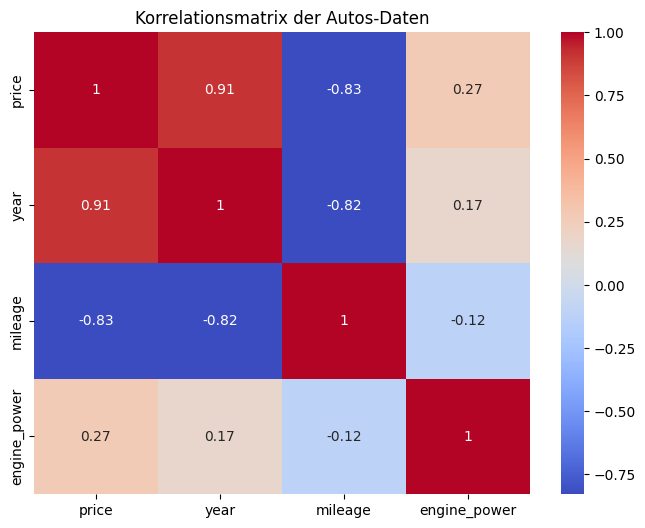

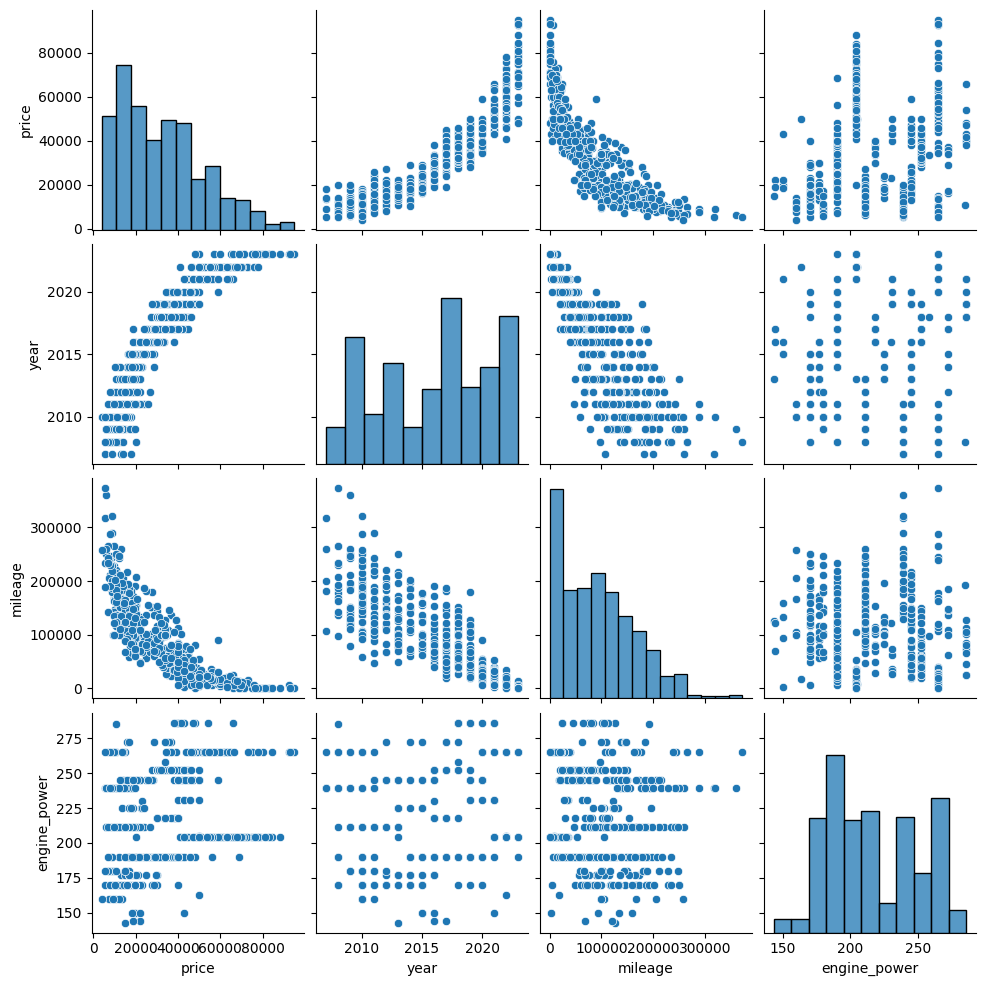

In [26]:
import psycopg2
import psycopg2.extras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Verbindung zur PostgreSQL-Datenbank herstellen
# Connect to PostgreSQL database
conn = psycopg2.connect(    host="localhost",
    database="postgres",
    user="postgres",
    password="admin")

# Cursor erstellen
cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)

# Alle verbleibenden Zeilen abrufen
cur.execute("SELECT * FROM autos")
results = cur.fetchall()

# DataFrame erstellen
autos_df = pd.DataFrame(results, columns=['id', 'model', 'price', 'currency', 'year', 'address', 'mileage', 'fuel_type', 'engine_power'])

# Formatänderungen für die Spalten 'year' und 'mileage' vornehmen
autos_df['year'] = pd.to_numeric(autos_df['year'].str.split('.').str[-1], errors='coerce')
autos_df['mileage'] = pd.to_numeric(autos_df['mileage'].str.replace("'", ''), errors='coerce')

# Korrelationsmatrix erstellen
correlation_matrix = autos_df[['price', 'year', 'mileage', 'engine_power']].corr()
print(correlation_matrix)

# Heatmap erstellen
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix der Autos-Daten')
plt.show()

# Streudiagramme erstellen
sns.pairplot(autos_df[['price', 'year', 'mileage', 'engine_power']])
plt.show()


# *Neuronales Netz mit Modelvorhersage*

In [27]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Daten vorbereiten
autos_df1 = autos_df.drop(columns=['model', 'currency'])  # Unnötige Spalten entfernen

# Nur Autos mit Benzin oder Diesel behalten
autos_df1 = autos_df1[autos_df1['fuel_type'].isin(['Benzin', 'Diesel'])]

# NaN-Werte in 'year' entfernen
#autos_df1 = autos_df1.dropna(subset=['year'])

# Daten in numerische Werte umwandeln
autos_df1['year'] = autos_df1['year'].astype(float)
autos_df1['mileage'] = autos_df1['mileage'].astype(float)
autos_df1['engine_power'] = autos_df1['engine_power'].astype(float)

# Teilen der Daten in Trainings- und Testdaten
X = autos_df1.drop(['address', 'price'], axis=1)  # 'address' und 'price'-Spalten entfernen
y = autos_df1['price']  # Verwenden Sie 'price' als Zielvariable

# Zielvariable normalisieren
y = (y - y.mean()) / y.std()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Vorverarbeitung der Daten
numeric_features = ['year', 'mileage', 'engine_power']
categorical_features = ['fuel_type']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Neuronales Netzwerk erstellen
model = Sequential()
#model.add(Dense(512, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

# Kompilieren des Modells
model.compile(loss='mean_squared_error', optimizer='adam')

# Modell trainieren
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Modell auf Testdaten evaluieren
mse_test = model.evaluate(X_test, y_test)
print(f'Mean Squared Error: {mse_test}')
print(f'Root Mean Squared Error: {math.sqrt(mse_test)}')




Epoch 1/100
11/11 [==============================] - 1s 19ms/step - loss: 0.9393 - val_loss: 0.9385
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8833 - val_loss: 0.8915
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8489 - val_loss: 0.8613
Epoch 4/100
11/11 [==============================] - 0s 6ms/step - loss: 0.8219 - val_loss: 0.8302
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7869 - val_loss: 0.7893
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7485 - val_loss: 0.7305
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7037 - val_loss: 0.6756
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6681 - val_loss: 0.6301
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6413 - val_loss: 0.5967
Epoch 10/100
11/11 [==============================] - 0s 6ms/step - loss: 0.6205 - val_loss: 0.5726
Epoch 1

# *Kontrolle*

In [7]:
print("Anzahl der NaN Werte in X_train: ", np.isnan(X_train).sum())
print("Anzahl der Infinity Werte in X_train: ", np.isinf(X_train).sum())
print("Anzahl der NaN Werte in y_train: ", np.isnan(y_train).sum())
print("Anzahl der Infinity Werte in y_train: ", np.isinf(y_train).sum())

print(X_train)

feature_names = preprocessor.get_feature_names_out()
print(feature_names)

Anzahl der NaN Werte in X_train:  0
Anzahl der Infinity Werte in X_train:  0
Anzahl der NaN Werte in y_train:  0
Anzahl der Infinity Werte in y_train:  0
[[ 0.4263136   0.1178522  -0.81430154  1.          0.        ]
 [-0.87039026  1.00210117 -1.40456066  1.          0.        ]
 [-1.7348595   2.34919921  1.39917017  1.          0.        ]
 ...
 [ 0.4263136  -0.49145061 -0.81430154  0.          1.        ]
 [ 0.21019629  0.04310553  1.60576086  0.          1.        ]
 [ 1.29078284 -1.16707208 -0.40112015  0.          1.        ]]
['num__year' 'num__mileage' 'num__engine_power' 'cat__fuel_type_Benzin'
 'cat__fuel_type_Diesel']


# *Visualisierung*

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2076 - val_loss: 0.1487
Epoch 2/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2058 - val_loss: 0.1472
Epoch 3/100
11/11 [==============================] - 0s 6ms/step - loss: 0.2039 - val_loss: 0.1454
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2022 - val_loss: 0.1438
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2004 - val_loss: 0.1423
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1987 - val_loss: 0.1409
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1970 - val_loss: 0.1394
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1953 - val_loss: 0.1381
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1936 - val_loss: 0.1368
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1921 - val_loss: 0.1355
Epoch 1

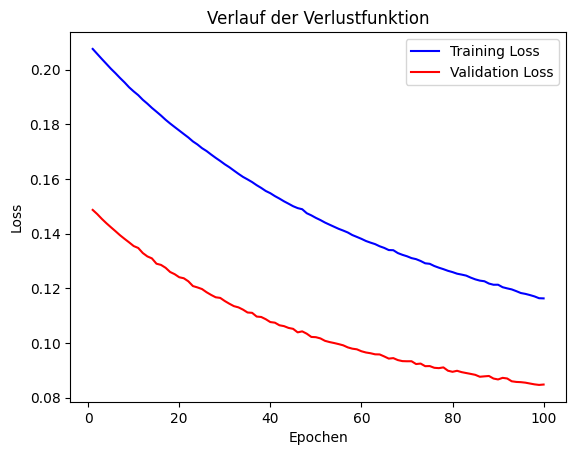

2/2 [==============================] - 0s 3ms/step


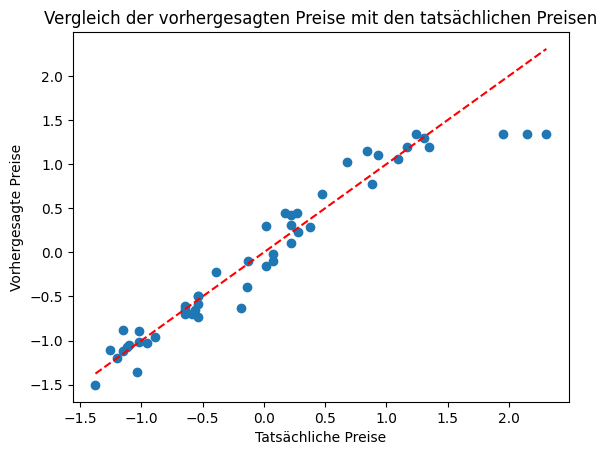

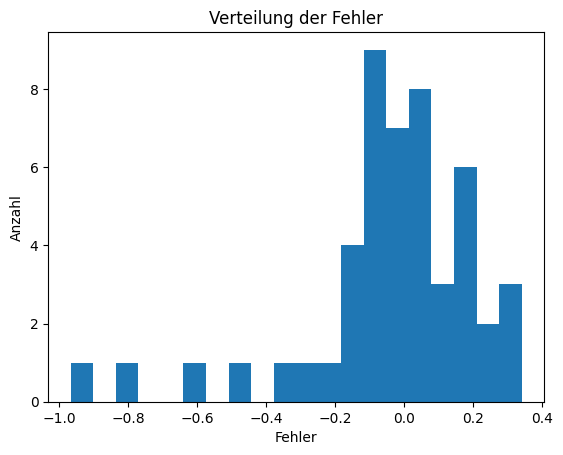

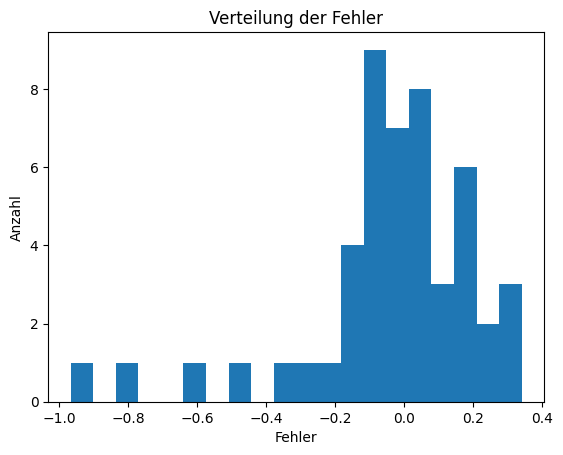

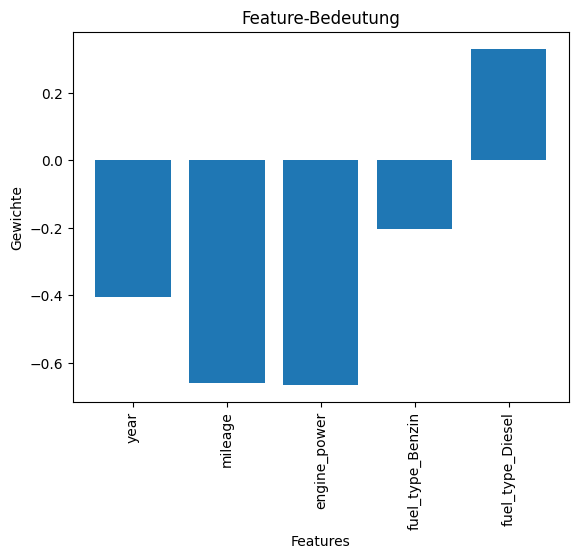

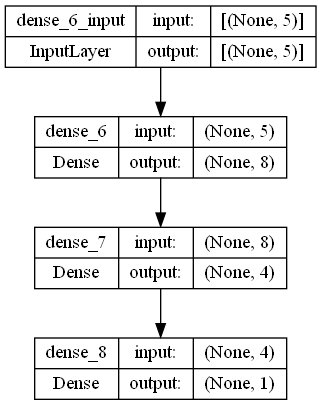

In [28]:
import matplotlib.pyplot as plt
import os
import pydot
from tensorflow.keras.utils import plot_model

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Trainings- und Validierungsverlust speichern
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Verlauf der Verlustfunktion')
plt.xlabel('Epochen')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Vorhersagen für das Testset erhalten
y_pred = model.predict(X_test)

# Scatterplot der vorhergesagten Preise vs. tatsächliche Preise
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Vergleich der vorhergesagten Preise mit den tatsächlichen Preisen')
plt.xlabel('Tatsächliche Preise')
plt.ylabel('Vorhergesagte Preise')
plt.show()

# Fehler berechnen
errors = y_pred.flatten() - y_test

# Histogramm der Fehler
plt.hist(errors, bins=20)
plt.title('Verteilung der Fehler')
plt.xlabel('Fehler')
plt.ylabel('Anzahl')
plt.show()

# Fehler berechnen
errors = y_pred.flatten() - y_test

# Histogramm der Fehler
plt.hist(errors, bins=20)
plt.title('Verteilung der Fehler')
plt.xlabel('Fehler')
plt.ylabel('Anzahl')
plt.show()

feature_weights = model.layers[0].get_weights()[0]

# Gewichte der Features erhalten
numeric_feature_names = preprocessor.transformers_[0][2]
categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out()

# Indexerstellung für die Features
feature_names = np.concatenate((numeric_feature_names, categorical_feature_names))
feature_weights = feature_weights.flatten()[:len(feature_names)]

# Balkendiagramm der Feature-Gewichte
plt.bar(feature_names, feature_weights)
plt.title('Feature-Bedeutung')
plt.xlabel('Features')
plt.ylabel('Gewichte')
plt.xticks(rotation=90)
plt.show()

from tensorflow.keras.utils import plot_model

# Modellarchitektur visualisieren
plot_model(model, to_file='model_architecture.png', show_shapes=True)


# *NLP & Random Forest Regressor*

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Laden Sie Ihre Daten in ein Pandas DataFrame.
df2 = autos_df

# Extrahieren Sie die relevanten Spalten für die Analyse.
data2 = df2[['model', 'mileage', 'year', 'price']]

# Aufteilen der Daten in Trainings- und Testdaten.
X_train, X_test, y_train, y_test = train_test_split(data2[['model', 'mileage', 'year']], data2['price'], test_size=0.2, random_state=42)

# Textvektorisierung des Modell-Features.
vectorizer = TfidfVectorizer()
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', vectorizer, 'model')],
    remainder='passthrough')

# Pipeline für Vorverarbeitung und Modelltraining erstellen.
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Modell trainieren.
pipeline.fit(X_train, y_train)

# Vorhersage des Preises für die Testdaten.
y_pred = pipeline.predict(X_test)

# Evaluierung des Modells mit dem Mean Squared Error (MSE).
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

#und weitere Metriken
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"Mean Absolute Percentage Error: {mape}%")

r2 = pipeline.score(X_test, y_test)
print(f"R-Squared: {r2}")

male = np.mean(np.abs(np.log1p(y_pred) - np.log1p(y_test)))
print(f"Mean Absolute Logarithmic Error: {male}")




Mean Squared Error: 23028994.389541913
Mean Absolute Percentage Error: 13.265969559934462%
R-Squared: 0.9336714623066045
Mean Absolute Logarithmic Error: 0.1292760195653871


# *Kontrolle plus Visualisierungen*

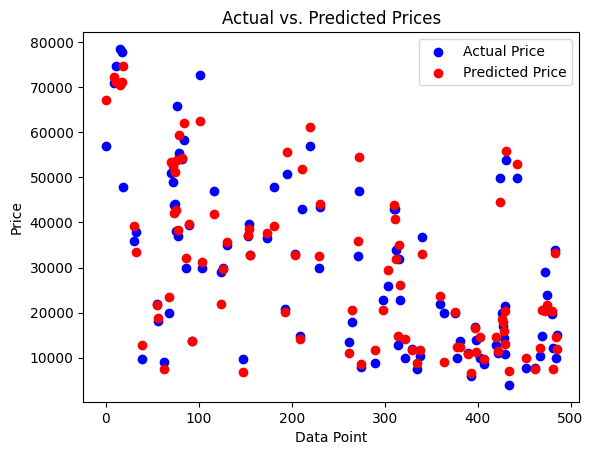

In [33]:
import matplotlib.pyplot as plt

# Erstellen Sie ein DataFrame mit den tatsächlichen Preisen und den Vorhersagen.
results = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})

# Streudiagramm der Vorhersagen und der tatsächlichen Preise erstellen.
plt.scatter(results.index, results['Actual Price'], color='b', label='Actual Price')
plt.scatter(results.index, results['Predicted Price'], color='r', label='Predicted Price')

# Diagramm beschriften
plt.xlabel('Data Point')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()

# Diagramm anzeigen
plt.show()


In [34]:
import pandas as pd

# Laden Sie Ihre Daten in ein Pandas DataFrame.
df3 = autos_df

# Fügen Sie eine neue Spalte hinzu, um das Vorhandensein von "S-Line" im Modell anzugeben.
df3['has_sline'] = df3['model'].apply(lambda x: 1 if 'S-Line' in x else 0)

# Extrahieren Sie die relevanten Spalten für die Analyse.
data = df3[['has_sline', 'price']]

# Berechnen Sie die Korrelation zwischen "has_sline" und "price".
correlation = data['has_sline'].corr(data['price'])
print(f"Korrelation: {correlation}")


Korrelation: 0.5975392440870295


Korrelation: 0.5975392440870295


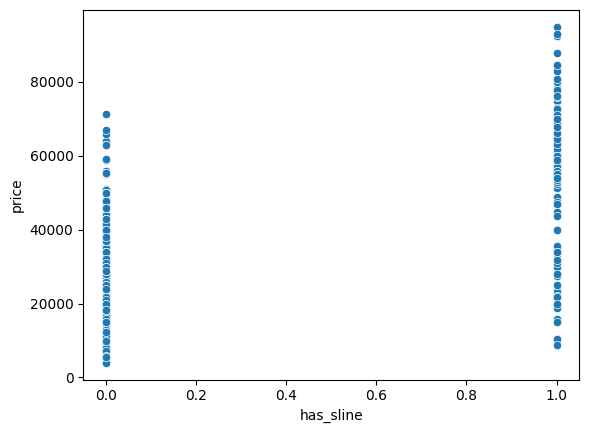

In [35]:
import pandas as pd
import seaborn as sns

# Laden Sie Ihre Daten in ein Pandas DataFrame.
df4 = autos_df

# Fügen Sie eine neue Spalte hinzu, um das Vorhandensein von "S-Line" im Modell anzugeben.
df4['has_sline'] = df4['model'].apply(lambda x: 1 if 'S-Line' in x else 0)

# Extrahieren Sie die relevanten Spalten für die Analyse.
data4 = df4[['has_sline', 'price']]

# Berechnen Sie die Korrelation zwischen "has_sline" und "price".
correlation = data4['has_sline'].corr(data4['price'])
print(f"Korrelation: {correlation}")

# Erstellen Sie ein Streudiagramm zur Visualisierung der Korrelation.
sns.scatterplot(data=data4, x='has_sline', y='price')

# Zeigen Sie das Streudiagramm an.
plt.show()
